#**Airbnb Occupancy Rate Prediction Model**

## Introduction
In this project, it aims to predict the **occupancy rate** of Airbnb listings using machine learning regression techniques. This will allow us to estimate how often a property will be booked based on its attributes such as **price**, **location** and **avilability**.

----
## Steps for Solving a Regression Problem:
1. **Find a suitable dataset:** Use Airbnb’s calendar dataset and listings dataset.

2. **Data Preparation:** This includes cleaning up and transforming the data to make it suitable for model training.

3. **Feature Engineering:** extract relevant features and calculate the target variable (occupancy rate).
4. **Train-Test Split:** Split the data into training and testing sets.
5. **Model Training:** Train the regressor using machine learning algorithms.
6. **Model Evaluation:** Evaluate the performance of the trained model.
7. **Prediction Results:** Use the model to predict occupancy rates for new or unseen listings.

# **Data Loading and Preprocessing**
---
## Loading the datasets
begin by loading two datasets:



*   **calendar_df:** Contains information about availability and prices over time for each listing.
* **listings_df:** Contains the property details, such as location, property type, and reviews.




In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             mean_squared_log_error, explained_variance_score,
                             max_error, median_absolute_error)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the datasets with low_memory=False to avoid memory issues
calendar_df = pd.read_csv('calendar.csv', low_memory=False)
listings_df = pd.read_csv('listings.csv', low_memory=False)

Use the `pd.read_csv()` function from the `pandas` library to load the datasets into DataFrames.

Setting `low_memory=False` prevents memory errors when loading large datasets.



### **Preprocessing the Data**
----
#### 1. Handling the availability column:
* The `available` column in the `calendar_df` indicates whether a listing is available on a given date (`'t'` means available, `'f'` means occupied).

* Map these values to binary numbers (1 for available and 0 for occupied) to facilitate calculations later.

#### 2. Cleaning the price column:
* The `price` column contains dollar signs and commas, so remove these and convert the price to a numerical format for future calculations.

#### 3. Ensuring consistent data types:
* To ensure the consistency between the `calendar_df` and `listings_df` DataFrames, convert the `listing_id` to string format in both DataFrames so we can merge them later.

In [ ]:
# Clean up the "available" column in calendar_df
calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})  # 't' means available, 'f' means occupied

# Clean and convert price column
calendar_df['price'] = calendar_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
calendar_df['price'] = pd.to_numeric(calendar_df['price'], errors='coerce')

# Convert listing_id to a consistent data type
calendar_df['listing_id'] = calendar_df['listing_id'].astype(str)
listings_df['listing_id'] = listings_df['id'].astype(str)


# **Feature Enginnering**
---
###**Calculate Occupancy Rate**
Calculate the occupancy rate for each listing toen a property is booked predict how oft, and, calculate the occupancy rate for each listing.

 This rate is computed as the number of days a listing is occupied divided by the total number of days it is listed.

 ---
 1. **Aggregating the data:**

 * Group the calendar data by listing_id and calculate:

  * `total_days`: The total number of days a listing is available in the dataset.
  * `occupied_days`: The number of days the listing is occupied (`1 - available` because `available = 0` means occupied).

 2. **Calculating occupancy rate:**

* The occupancy rate is calculated as the percentage of days a listing is occupied.

3. **Merge Occupancy Rate with Listings Data**

In [ ]:
# Calculate occupancy rate per listing
occupancy_rate_df = calendar_df.groupby('listing_id').agg(
    total_days=('available', 'count'),
    occupied_days=('available', lambda x: (1 - x).sum())
).reset_index()

# Calculate occupancy rate
occupancy_rate_df['occupancy_rate'] = (occupancy_rate_df['occupied_days'] / occupancy_rate_df['total_days']) * 100

# Merge occupancy rate with the listings data
merged_df = pd.merge(listings_df, occupancy_rate_df, on='listing_id', how='inner')


# **Data Preprocessing**

---
##1. Feature Selection and Cleanup
For the regression model, select a subset of columns from the merged DataFrame that are relevant for predicting the occupancy rate. This includes property type, room type, price, location, and reviews.


##2.  Handling Missing and Categorical Data
Clean the `bathrooms_text` column by extracting numerical values, as this column may contain text descriptions like "2 bathrooms". Then, we handle missing values in the numerical columns by imputing the median.


##3. Encode Categorical Variables
encode categorical variables (property_type and room_type) using one-hot encoding and scale the numerical features for better performance in the model.

In [ ]:
# Adjusted list of columns to keep
columns_to_keep = [
    'listing_id', 'property_type', 'room_type', 'price', 'bedrooms',
    'bathrooms_text', 'latitude', 'longitude', 'availability_365',
    'reviews_per_month', 'minimum_nights', 'occupancy_rate'
]

merged_df['price'] = merged_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Keep only these columns
cleaned_df = merged_df[columns_to_keep].copy()

In [ ]:
# Check if 'bathrooms_text' is in the dataframe before attempting to clean it
if 'bathrooms_text' in cleaned_df.columns:
    # Extract numerical value from 'bathrooms_text' (if necessary)
    def extract_bathrooms(bathroom_text):
        if isinstance(bathroom_text, str):
            match = re.search(r'(\d+\.?\d*)', bathroom_text)
            if match:
                return float(match.group(1))
        return np.nan

    cleaned_df['bathrooms'] = cleaned_df['bathrooms_text'].apply(extract_bathrooms)
    cleaned_df.drop(columns=['bathrooms_text'], inplace=True)  # Drop 'bathrooms_text' column


In [ ]:
# Impute missing values for numerical features
imputer = SimpleImputer(strategy='median')
cleaned_df[['price', 'bedrooms', 'reviews_per_month', 'minimum_nights']] = imputer.fit_transform(cleaned_df[['price', 'bedrooms', 'reviews_per_month', 'minimum_nights']])

# One-hot encode categorical variables
cleaned_df = pd.get_dummies(cleaned_df, columns=['property_type', 'room_type'], drop_first=True)

# Scale the numerical features
scaler = StandardScaler()
numerical_features = ['price', 'bedrooms', 'availability_365', 'reviews_per_month', 'minimum_nights']
cleaned_df[numerical_features] = scaler.fit_transform(cleaned_df[numerical_features])

# **Train-Test Split and Define Features**
---
### **Define Feature and Target**
* Define the input feature (`X` and the target variable (`y`). The target variable is the **occupancy rate**, while the features are property attributes such as price, bedrooms and reviews.

### **Split Data into Training and Testing Sets**
* Split the data into training and testing sets, with 80% of the data used for training the model and 20% used for evaluating the model's performance

### **Handing Missing or Infinite Values**
* Before training the model, replace infinite values with NaN and drop any rows with NaN values to ensure clean data.
Also align the indices of `X_train`, `y_train`, `X_test`, and `y_test`.

In [ ]:
# Define features (X) and target (y)
X = cleaned_df.drop(columns=['listing_id', 'occupancy_rate'])  # Features
y = cleaned_df['occupancy_rate']  # Target

In [ ]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Replace infinite values with NaN and drop rows with NaN
X_train_cleaned = X_train.replace([np.inf, -np.inf], np.nan).dropna()
X_test_cleaned = X_test.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure y_train and y_test have no NaN values
y_train_cleaned = y_train.loc[X_train_cleaned.index].fillna(0)
y_test_cleaned = y_test.loc[X_test_cleaned.index].fillna(0)

# Reset indices for alignment
X_train_cleaned = X_train_cleaned.reset_index(drop=True)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)
X_test_cleaned = X_test_cleaned.reset_index(drop=True)
y_test_cleaned = y_test_cleaned.reset_index(drop=True)

# **Model Training and Hyperparameter Tuning**
---
### **Train Gradient Boosting Regressor**
* Train a **Gradient Boosting Regressor** on the cleaned training data. GB is an ensemble that builds sequential models to correct errors made by previous models.

### **Hyperparameter Tuning**
* Optimise the hyperparameters of the model using **RandomisedSearchCV**, which speeds up the tuning process by testing random combinations of hyperparameters. This helps the model find the best model.

In [ ]:
# Train a Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_cleaned, y_train_cleaned)

# Optimised RandomizedSearchCV for faster tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}
random_search = RandomizedSearchCV(gbr, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train_cleaned, y_train_cleaned)

# Best model and predictions
best_gbr_model = random_search.best_estimator_
y_pred = best_gbr_model.predict(X_test_cleaned)


# **Model Evaluation and Prediction**
---
### **Model Evaluation Metircs**
After training the best model, evaluate its performance on the test set using several metrics, including:

* Mean Squared Error (MSE)
* Root Mean Squared Error (RMSE)
* Mean Absolute Error (MAE)
* R-squared (R²)
* Adjusted R-squared (Adjusted R²)




In [ ]:
# Evaluation metrics
mse = mean_squared_error(y_test_cleaned, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_cleaned, y_pred)
r2 = r2_score(y_test_cleaned, y_pred)

n = len(y_test_cleaned)
p = X_test_cleaned.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print all metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.027722734480940675
Root Mean Squared Error (RMSE): 0.16650145489136325
Mean Absolute Error (MAE): 0.02036965718179855
R-squared (R²): 0.9999735102742793


In [ ]:
# Display a comparison of actual vs predicted occupancy rates
comparison_df = pd.DataFrame({
    'Actual Occupancy Rate': y_test_cleaned,
    'Predicted Occupancy Rate': y_pred
})

# Display the first 10 rows of the comparison
print(comparison_df.head(10))

   Actual Occupancy Rate  Predicted Occupancy Rate
0              81.917808                 81.914227
1              75.616438                 75.613903
2               1.369863                  1.387166
3               4.383562                  4.389320
4              53.972603                 53.972828
5              91.780822                 91.752305
6              41.369863                 41.335380
7              49.863014                 49.921695
8              75.342466                 75.339811
9              16.986301                 16.986834


In [ ]:
# Cross-Validation scores
cv_scores = cross_val_score(best_gbr_model, X_train_cleaned, y_train_cleaned, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean Cross-Validation R-squared: {cv_scores.mean()}")

Cross-Validation R-squared Scores: [0.99988189 0.99993973 0.99996484 0.99918035 0.99732724]
Mean Cross-Validation R-squared: 0.9992588099628769


# **Visualisation**
---
### **Residuals Plot**
Plot the residuals (the difference between actual and predicted occupancy rates) to check for any patterns that may indicate issues with the model's predictions.

### **Predicted vs Actual Plot**
This plot shows the predicted occupancy rates versus the actual occupancy rates. A perfect model would have all points lie on the diagonal line.




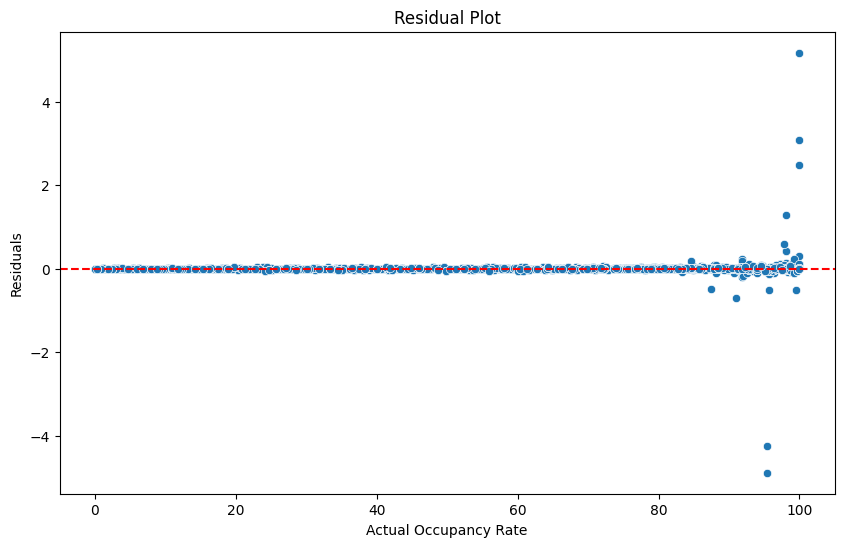

Top 10 Residuals:
2633    5.169492
2964    4.887835
1839    4.239428
931     3.069735
1118    2.470309
1352    1.275223
205     0.714503
2492    0.592060
327     0.516950
388     0.516014
Name: occupancy_rate, dtype: float64


In [ ]:
# Plot residuals
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test_cleaned, y=y_test_cleaned - y_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Occupancy Rate')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Identify top residuals
residuals = y_test_cleaned - y_pred
top_residuals = residuals.abs().nlargest(10)
print("Top 10 Residuals:")
print(top_residuals)

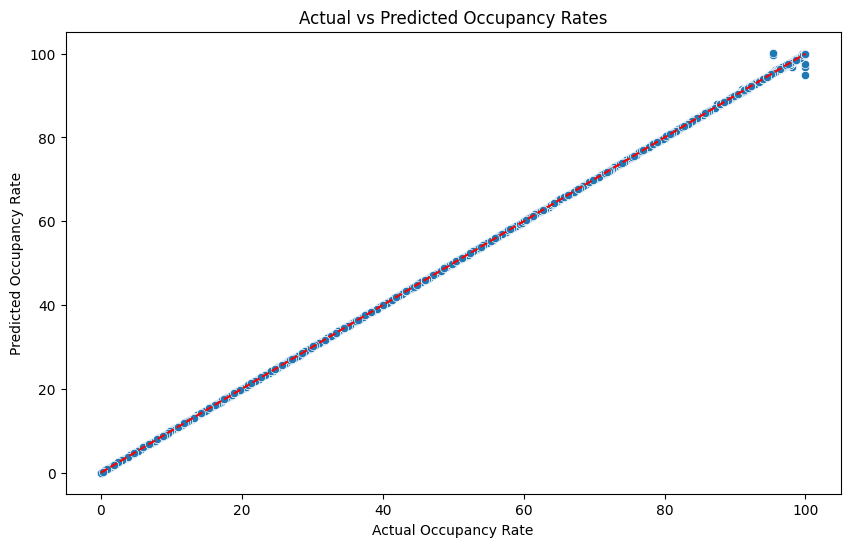

In [ ]:
# Visualize predicted vs actual
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test_cleaned, y=y_pred)
plt.plot([y_test_cleaned.min(), y_test_cleaned.max()], [y_test_cleaned.min(), y_test_cleaned.max()], 'r--')
plt.xlabel('Actual Occupancy Rate')
plt.ylabel('Predicted Occupancy Rate')
plt.title('Actual vs Predicted Occupancy Rates')
plt.show()

# **Comparison Models**
-----
Compare to the performance
- Random Forest Regressor model to train dataset. And find which models are more fitting for the task.

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train_cleaned, y_train_cleaned)
y_pred_rf = rf_model.predict(X_test_cleaned)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test_cleaned, y_pred_rf)
r2_rf = r2_score(y_test_cleaned, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")
print(f"R-squared (Random Forest): {r2_rf}")

Mean Squared Error (Random Forest): 0.02932344614154178
R-squared (Random Forest): 0.9999719807565877
